In [37]:
import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

In [38]:
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]


df = pd.read_csv('/Users/password1234/Documents/Machine Learning/census-income.data.csv', header=None, names=header_names)
df_test = pd.read_csv('/Users/password1234/Documents/Machine Learning/census-income.test.csv', header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df.drop(columns=['instance_weight']) ## not used for our analysis

categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [39]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 29 columns):
age                 299285 non-null int64
class_worker        299285 non-null category
det_ind_code        299285 non-null category
det_occ_code        299285 non-null category
education           299285 non-null category
wage_per_hour       299285 non-null int64
hs_college          299285 non-null category
marital_stat        299285 non-null category
major_ind_code      299285 non-null category
major_occ_code      299285 non-null category
race                299285 non-null category
hisp_origin         299285 non-null category
sex                 299285 non-null category
union_member        299285 non-null category
unemp_reason        299285 non-null category
full_or_part_emp    299285 non-null category
capital_gains       299285 non-null int64
capital_losses      299285 non-null int64
stock_dividends     299285 non-null int64
tax_filer_stat      299285 non-null category
insta

In [40]:
## test set for feature selection
selection_df = df.sample(frac = .2)

In [41]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

In [42]:
### Preprocess the data
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns
X_selection = selection_df.drop(target, axis=1)
y_selection = selection_df[target]
preprocessor = preprocess_pipeline(numeric_features, categorical_features)
X_selection_preprocessed = preprocessor.fit_transform(X_selection)

In [43]:
### Make a list of all the columns after one hot encoding
ohe = preprocessor['preprocessor'].named_transformers_['cat']['onehot']
cat_processed = ohe.get_feature_names(X_selection[categorical_features].columns)
all_processed_cols = np.concatenate((numeric_features, cat_processed), axis=0)

Optimal number of features : 209


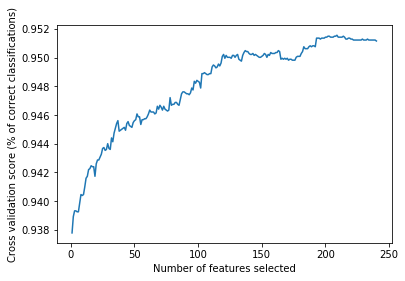

In [33]:
import warnings
warnings.filterwarnings('ignore')

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv = RFECV(clf, step=1, cv=5)
rfecv.fit(X_selection_preprocessed, y_selection)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [44]:
### Show all selected features
selected_features = all_processed_cols[rfecv.support_]
print(selected_features)
X = sampleDF.drop(target, axis=1)
y = sampleDF[target]
X_preprocessed = preprocessor.fit_transform(X)
X_selected = X_preprocessed.tocsr()[:,rfecv.support_] #index columns of sparse matrix

['age' 'capital_gains' 'capital_losses' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Federal government'
 'class_worker_ Local government' 'class_worker_ Not in universe'
 'class_worker_ Self-employed-incorporated'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ State government' 'class_worker_ Without pay'
 'det_ind_code_0' 'det_ind_code_1' 'det_ind_code_2' 'det_ind_code_3'
 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_6' 'det_ind_code_7'
 'det_ind_code_8' 'det_ind_code_9' 'det_ind_code_11' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_18'
 'det_ind_code_19' 'det_ind_code_20' 'det_ind_code_21' 'det_ind_code_22'
 'det_ind_code_23' 'det_ind_code_24' 'det_ind_code_25' 'det_ind_code_26'
 'det_ind_code_28' 'det_ind_code_29' 'det_ind_code_31' 'det_ind_code_32'
 'det_ind_code_33' 'det_ind_code_35' 'det_ind_code_36' 'det_ind_code_37'
 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_41' 'det_ind_code_42'
 'det_ind_code

In [45]:
#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=1)

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt

In [18]:
#### Using the classification_pipeline function Decision Tree
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV.fit(X_selected, y)
    
print('Best Score: {s}'.format(s=CV.best_score_))
print('Best Parameters: {p}'.format(p=CV.best_params_))  

Best Score: 0.9459144293900463
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'random'}


In [47]:
#getting prediction accuracy for Decision Tree

dt_clf = DecisionTreeClassifier(criterion = 'gini', 
                                splitter = 'random', 
                                min_samples_split = 3, 
                                min_samples_leaf = 3)


# train the decision tree algorithm
%time dt_clf.fit(X_train,y_train)
yhat = dt_clf.predict(X_test)
print ('accuracy:', mt.accuracy_score(y_test,yhat))

CPU times: user 7.66 s, sys: 35.3 ms, total: 7.7 s
Wall time: 7.6 s
accuracy: 0.9446184688635509


<BarContainer object of 209 artists>

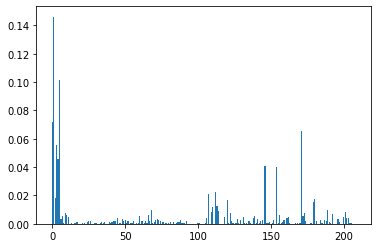

In [48]:
#Feature importance graph
imp = dt_clf.feature_importances_

#Plt
plt.bar(range(len(imp)), imp)